HOMEWORK 4: CROSS VALIDATION

# Questions

In this homework, you will do a cross validation for
BioModels model 45. The model has the floating species EC, X, Y, Z, and the parameters (variables)
beta, vin_v0, vin_v1, v2i_Vm2i, v2i_K2i, v3i_Vm3i, v3i_K3y, v3i_K3z, v4_Kf, v5_K,
v6_Kf, v2s_Vm2s, v2s_K2s, v3s_Vm3s, v3s_K3s.


1. (20 pts) Create synthetic data for the floating species.
Using the values of the parameter in the published model:
   1. Write a function that creates synthetic data by adding a normally distributed error with a parameter specified standard deviation.
   1. Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.4.
   
1. (60 pts) Implement codes that do cross validation and report model $R^2$ and parameter variability.
Feel free to make use of the codes from class and/or the codes in the "Helpers" section.
   
1. (20 pts) Do a 2, 5, and 10 fold cross validation using alternating folds for the 3 datasets. That is, fold 1 has the points 1, 11, 21, ..;
fold 2 has the points 2, 12, 22, ...; and so on. 
   1. How is parameter variability affected
by the number of folds?
   1. How is parameter variability affected by the variability of the training data?
   
1. (10 pt) Extra credit. How would you frame the analysis in (3) using the language of design of experiments.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
try:
    import SBstoat
except:
    !pip install -q SBstoat
    import SBstoat

## Constants

In [39]:
ENDTIME = 60
NUMPOINT = 1200
NOISE_STDS = [0.1, 0.2, 0.4]
# Column names
C_NOISE_STD = "noise_ std"
C_NUM_PARAMETER = "no. parameters"
C_VALUE = "value"
C_TIME = "time"
#

## BioModels 45

In [6]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index(C_TIME)
    return df

# Tests
if False:
    arr = np.array(range(10))
    arr = np.reshape(arr, (2, 5))
    df = arrToDF(arr)
    assert(isinstance(df, pd.DataFrame))

In [34]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

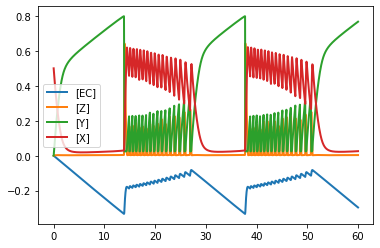

In [10]:
# Values of model parameters in the model
MODEL_PRM_DCT = {
    "beta": 1,
    "vin_v0": 0.015,
    "vin_v1": 0.012,
    "v2i_Vm2i": 3.1,
    "v2i_K2i": 0.005,
    "v3i_Vm3i": 25, 
    "v3i_K3y": 0.065,
    "v3i_K3z": 0.022,
    "v4_Kf": 0.5,
    "v5_K": 1,
    "v6_Kf": 0.5,
    "v2s_Vm2s": 1.5,
    "v2s_K2s": 0.0265,
    "v3s_Vm3s": 0.169,
    "v3s_K3s": 0.1,
}
MODEL_PRMS = list(MODEL_PRM_DCT.keys())
MODEL_RR.reset()
MODEL_ARR = MODEL_RR.simulate(0, 60, 1200)
MODEL_RR.plot(MODEL_ARR)
MODEL_DF = arrToDF(MODEL_ARR)

## Helper Functions

In [17]:
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = list(set(indices).difference(testIndices))
        yield trainIndices, testIndices
        
# Tests
numpoint = 6
numfold = 3
generator = foldGenerator(numpoint, numfold)
folds = list(generator)
assert(len(folds) == numfold)
for fold in folds:
    composite = list(fold[0])
    composite.extend(fold[1])
    assert(len(composite) == numpoint)

In [ ]:
def plotDF(df, ax=None, linetype="scatter", title="", isPlot=True):
    """
    Plots the variables in a DataFrame.
    
    Parameters
    ----------
    df: DataFrame
    ax: Matplotlib.axes
    linetype: str
    title: str
    isPlot: bool
        Show the plot
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    else:
        fig = None
    legend = []
    for col in df.columns:
        legend.append(col)
        if linetype == "scatter":
            _ = ax.scatter(df.index, df[col])
        else:
           _ = ax.plot(df.index, df[col])
    _ = ax.set_xlabel("time")
    _ = ax.set_title(title)
    _ = plt.legend(legend)
    if not isPlot:
        if fig is not None:
            fig.clear()
    return ax

# Tests
_ = plotDF(MODEL_DF, linetype="line", isPlot=False)

In [37]:
def makeSyntheticData(df, std):
    """
    Creates synthetic data by adding a normally distributed random variable with mean zero and the specified
    standard deviation.
    
    Parameters
    ----------
    df: DataFrame
    std: float
    
    Returns
    -------
    DataFrame with same index and column names as df
    """
    timeseries = SBstoat.NamedTimeseries(dataframe=df)
    synthesizer = SBstoat.ObservationSynthesizerRandomErrors(fittedTS=timeseries, std=std)
    syntheticTS = synthesizer.calculate()
    return syntheticTS.to_dataframe()

#TESTS
observedDF = makeSyntheticData(MODEL_DF, 0)
assert(observedDF.equals(MODEL_DF))

In [36]:
class CrossValidator(object):
    """Performs cross validation using parameter fitting."""
    
    # Dataframe columns and dictionary keys
    PREDICTED = "predicted"
    TRUE = "true"
    FOLD = "fold"
    RSQ = "rsq"
    PARAMETER = "parameter"
    
    def __init__(self, numFold, 
                 model=MODEL_ANT, observedDF=MODEL_DF, parameterNames=MODEL_PRMS,
                 trueParameterDct=None):
        """
        numFold: int
            number of folds
        model: str (Antimony Model)
        observedDF: DataFrame
        paramterNames: list-str
        trueParameterDct: dict
            key: parameter name, value: parameter value
        """
        self.numFold = numFold
        self.model = model
        self.observedDF = observedDF.copy()
        self.parameterNames = parameterNames
        self.colnames = self.observedDF.columns
        self.trueParameterDct = trueParameterDct
        self.endTime = np.max(self.observedDF.index)
        self.numPoint = len(self.observedDF)
        self.parametersCol = None
        self.rsqs = None
        self.fitters = None

    @staticmethod
    def _calcRsq(observedDF, fittedDF):
        columns = observedDF.columns
        residualsArr = observedDF.values - fittedDF.values
        rsq = 1 - np.var(residualsArr)/np.var(observedDF.values)
        return rsq

    def execute(self):
        generator = foldGenerator(self.numPoint, self.numFold)
        indexArr = np.array(self.observedDF.index)
        self.parametersCol = []
        self.rsqs = []
        self.fitters = []
        for trainIdxs, testIdxs in generator:
            trainIndices = indexArr[trainIdxs]
            testIndices = indexArr[testIdxs]
            observedDF = self.observedDF.copy()
            observedDF.loc[testIndices] = np.nan
            observedTS = SBstoat.NamedTimeseries(dataframe=observedDF)
            fitter = SBstoat.ModelFitter(self.model, observedTS,
                                  self.parameterNames,
                                  endTime=self.endTime,
                                  numPoint=self.numPoint)
            self.fitters.append(fitter)
            fitter.fitModel()
            fittedDF = fitter.fittedTS.to_dataframe()
            self.parametersCol.append(fitter.params.copy())
            rsq = self._calcRsq(self.observedDF.loc[testIndices, :],
                  fittedDF.loc[testIndices, :])
            self.rsqs.append(rsq)

    def reportParameters(self):
        """
        Constructs a report for the parameter values by fold.
        
        Returns
        -------
        pd.DataFrame
        """
        if self.trueParameterDct is  None:
            raise ValueError("Must construct CrossValidator with trueParameterDct")
        # Construct parameter information
        keys = [CrossValidator.FOLD, CrossValidator.TRUE,
              CrossValidator.PREDICTED, CrossValidator.PARAMETER]
        dct = {}
        for key in keys:
            dct[key] = []
        for fold in range(len(self.parametersCol)):
            for parameterName in self.parameterNames:
                dct[CrossValidator.FOLD].append(fold)
                dct[CrossValidator.PARAMETER].append(parameterName)
                dct[CrossValidator.TRUE].append(
                      self.trueParameterDct[parameterName])
                dct[CrossValidator.PREDICTED].append(
                      self.parametersCol[fold].valuesdict()[parameterName])
        reportDF = pd.DataFrame(dct)
        #
        return reportDF
    
    def reportRsq(self):
        return pd.DataFrame({CrossValidator.RSQ: self.rsqs})
    
# Tests
# Constructor
validator = CrossValidator(3, parameterNames=["beta"])
assert(validator.endTime == ENDTIME)
# calcRSQ
observedDF = makeSyntheticData(MODEL_DF, 0)
rsq = validator._calcRsq(observedDF, MODEL_DF)
assert(rsq == 1)
# execute
validator.execute()
assert(np.mean(validator.rsqs) > 0.95)

# Question 1: Generate Synthetic Observations

In [40]:
SYNTHETIC_DCT = {s: makeSyntheticData(MODEL_DF, s) for s in NOISE_STDS}

<AxesSubplot:xlabel='time'>

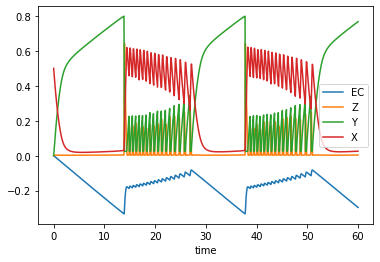

In [43]:
MODEL_DF.plot()

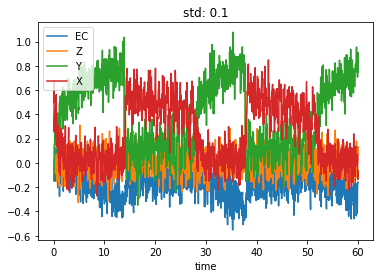

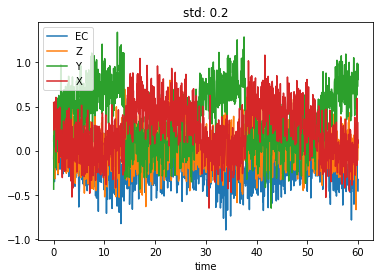

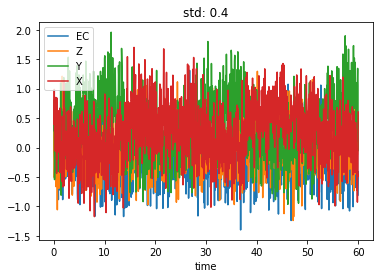

In [45]:
for std in NOISE_STDS:
    ax = SYNTHETIC_DCT[std].plot()
    ax.set_title("std: " + str(std))